# Transferencia de Estilo Neuronal

En este proyecto implemento un algoritmo de **Transferencia de Estilo Neuronal** (Neural Style Transfer, NST), propuesto originalmente por [*Gatys et al.* (2015).](https://arxiv.org/abs/1508.06576)

La NST es una técnica de optimización dentro del deep learning que permite combinar el **contenido** de una imagen $C$ con el **estilo** de otra imagen $S$, para generar una nueva imagen $G$ que conserva la estructura de la primera y adopta la apariencia artística de la segunda.

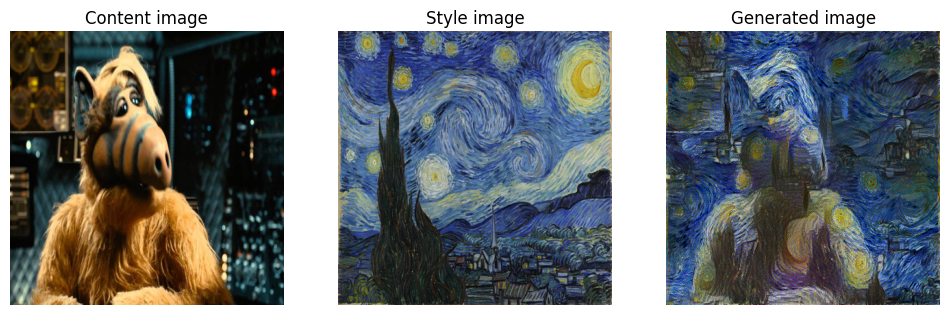

In [ ]:
# Here is an example of what this algorithm is capable of producing
from PIL import Image
Image.open('images/example.png')

## 1 - Paquetes

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
import matplotlib.pyplot as plt
from PIL import Image

## 2 - Transfer Learning

La Transferencia de Estilo Neuronal se apoya en **Transfer Learning**, es decir, el uso de una red previamente entrenada para resolver una tarea diferente a la original.

En este caso utilizamos **VGG-19**, una red convolucional de 19 capas ampliamente reconocida, entrenada sobre la enorme base de datos **ImageNet**. Gracias a este entrenamiento previo, VGG-19 ha aprendido a reconocer:

- características de **bajo nivel** (bordes, contornos, texturas simples) en sus capas más superficiales, y  
- características de **alto nivel** (formas complejas, partes de objetos, clases) en sus capas más profundas.

La siguiente celda carga los parámetros preentrenados del modelo VGG-19.

In [ ]:
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')
vgg.trainable = False
vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 400, 400, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 400, 400, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 400, 400, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 200, 200, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 200, 200, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 200, 200, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 100, 100, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 100, 100, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 100, 100, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 100, 100, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 100, 100, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 50, 50, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 50, 50, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 50, 50, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 25, 25, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

## 3 - Algoritmo

El algoritmo completo de Transferencia de Estilo Neuronal se construye en tres pasos:

1. **Función de coste del contenido** $J_{\text{content}}(C, G)$
2. **Función de coste del estilo** $J_{\text{style}}(S, G)$
3. **Función de coste total**, que combina ambas: $J(G) = \alpha \, J_{\text{content}}(C, G) + \beta \, J_{\text{style}}(S, G)$

### 3.1 - Función de coste del contenido

Primero, es importante entender la diferencia entre las capas **superficiales** y **profundas** de una red convolucional::

* Las capas más superficiales suelen detectar características de bajo nivel, como *bordes y texturas simples*.
* Las capas más profundas detectan características de alto nivel, como *patrones más complejas y clases de objetos*.

En el contexto de NST, se elige una capa cuyas activaciones representarán el contenido de una imagen. En la práctica, los resultados visualmente más agradables suelen obtenerse utilizando una capa intermedia de la red: ni demasiado superficial ni demasiado profunda.

Uno de los objetivos al realizar NST es que el contenido de la imagen generada $G$ coincida con el de la imagen $C$. Para lograrlo, se define una función que mide qué tan diferentes son sus representaciones de contenido; al minimizar esta diferencia, el contenido de $G$ se aproxima al de $C$. Esta función se conoce como función de coste de contenido y se define como:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum_{\text{todas las entradas}} (a^{(C)} - a^{(G)})^2 \tag{1}$$

* $a^{(C)}$ y $a^{(G)}$ son las activaciones de la capa elegida obtenidas al pasar por separado las imágenes $C$ y $G$ a través de la red.

* $n_H$, $n_W$ y $n_C$ son la altura, el ancho y el número de canales de la capa elegida, y se usan para normalizar el coste.

In [ ]:
def compute_content_cost(a_C, a_G):
    """
    a_C, a_G: content layer activations (shape (1, n_H, n_W, n_C))
    """

    # Retrieve dimensions from a_G
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape 'a_C' and 'a_G' to (1, n_H*n_W, n_C)
    a_C_unrolled = tf.reshape(a_C, shape=[-1, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[-1, n_H * n_W, n_C])

    # compute the cost with tensorflow
    denom = 4.0 * n_H * n_W * n_C
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / denom

    return J_content

### 3.2 - Función de coste del estilo

La **matriz de Gram**, también llamada *matriz de estilo*, es la herramienta utilizada para representar el estilo. Esta matriz compara qué tan similares son entre sí un conjunto de vectores $(v_1, \ldots, v_n)$ mediante productos punto. En particular:

$$G_{\text{gram}}(i, j) = v_i^{T} v_j = \text{np.dot}(v_i, v_j)$$

Se puede calcular una matriz de Gram por capa, donde los vectores corresponden a los mapas de activación **desenrollados** en sus dimensiones espaciales $(n_H \times n_W)$. Así, el cálculo de la matriz de Gram se obtiene multiplicando la matriz de activaciones desenrolladas por su traspuesta:

$$G_{\text{gram}} = A_{\text{unrolled}} \, A_{\text{unrolled}}^{T}$$

El resultado es una matriz de dimensiones $(n_C, n_C)$, donde $n_C$ es el número de canales.

El valor $G_{\text{gram}}(i, j)$ mide la **correlación** entre las activaciones del filtro $i$ y las del filtro $j$.  
Los elementos diagonales $G_{\text{gram}}(i, i)$ indican la **prevalencia de patrones o texturas**, ya que reflejan qué tan “activo” es un filtro. Por ejemplo, si el filtro $i$ detecta texturas verticales, entonces $G_{\text{gram}}(i, i)$ mide qué tan comunes son dichas texturas en la imagen.


#### 3.2.1 - Coste del estilo para una capa

Definimos primero el coste del estilo para una sola capa $l$:

$$J_{\text{style}}^{[l]}(S, G)
= \frac{1}{4 \, n_C^2 \, (n_H n_W)^2}
\sum_{i=1}^{n_C} \sum_{j=1}^{n_C}
\left( G_{\text{gram}}^{(S)}(i, j) - G_{\text{gram}}^{(G)}(i, j) \right)^2$$

* $G_{\text{gram}}^{(S)}$: matriz de Gram de la imagen **estilo**.  
* $G_{\text{gram}}^{(G)}$: matriz de Gram de la imagen **generada**.

In [ ]:
def compute_layer_style_cost(a_S, a_G):
    """
    a_S, a_G: tensors shape (1, n_H, n_W, n_C)
    returns scalar J_style_layer
    """

    # squeeze batch dim
    a_S = tf.squeeze(a_S)  # (n_H, n_W, n_C)
    a_G = tf.squeeze(a_G)

    # get shapes
    n_H, n_W, n_C = a_G.shape[0], a_G.shape[1], a_G.shape[2]

    # reorder to (n_C, n_H * n_W)
    a_S = tf.transpose(a_S, perm=[2, 0, 1])   # (C, H, W)
    a_G = tf.transpose(a_G, perm=[2, 0, 1])
    a_S = tf.reshape(a_S, [n_C, n_H * n_W])
    a_G = tf.reshape(a_G, [n_C, n_H * n_W])

    # Gram matrices
    GS = tf.matmul(a_S, a_S, transpose_b=True)  # (C, C)
    GG = tf.matmul(a_G, a_G, transpose_b=True)

    # loss: 1 / (4 * n_C^2 * (n_H * n_W)^2) * sum((GS - GG)^2)
    denom = 4.0 * (n_C ** 2) * (n_H * n_W) ** 2
    J_style_layer = tf.reduce_sum(tf.square(GS - GG)) / denom

    return J_style_layer

#### 3.2.3 - Coste total del estilo

Hasta aquí se ha capturado el estilo correspondiente a una sola capa. Sin embargo, a diferencia del contenido (que suele requerir solo una capa), los resultados mejoran al combinar los costes de estilo de **varias capas**. A cada capa se le asigna un peso $\lambda^{[l]}$ que determina cuánto contribuye a la representación del estilo.

Así, la función de coste total del estilo —que al minimizarla hace que la imagen generada $G$ siga el estilo de $S$— se define como:

$$J_{\text{style}}(S, G)
= \sum_{l} \lambda^{[l]} \, J_{\text{style}}^{[l]}(S, G)\tag{2}$$

In [ ]:
def compute_style_cost(a_S, a_G, style_layers):
    """
    a_S: list of style activations from style image
    a_G: list of style activations from generated image
    style_layers: list of tuples (layer_name, weight)
    """

    # initialize the overall style cost
    J_style = 0.0

    # iterate by index
    for i, (layer_name, weight) in enumerate(style_layers):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight * J_style_layer
    return J_style

### 3.3 - Definición del coste total a optimizar

La **función de coste total** combina el coste de contenido y el de estilo. Su objetivo es encontrar una imagen generada $G$ que preserve la estructura de la imagen $C$ y adopte el estilo de la imagen $S$. La fórmula es:

$$J(G) = \alpha \, J_{\text{content}}(C, G) + \beta \, J_{\text{style}}(S, G)$$

donde los hiperparámetros $\alpha$ y $\beta$ controlan el peso relativo entre contenido y estilo.

In [ ]:
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 80):
    """
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    """

    J = alpha*J_content + beta*J_style

    return J

## 4 - Previo al entrenamiento

### 4.1 Cargar la imagen de contenido
La siguiente celda carga la imagen de contenido $C$ y redimensiona su tamaño.  
En este ejemplo utilizo una fotografía de mi extraterrestre favorito: **Alf**.

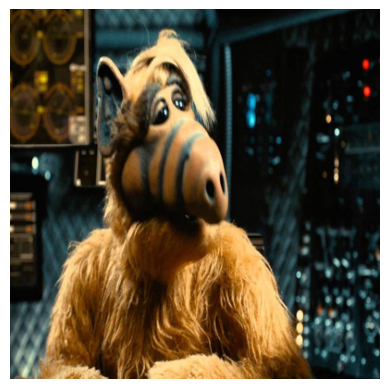

In [ ]:
def load_img(path, img_size):
    # Asegurar 3 canales (RGB) y redimensionar con PIL
    img_pil = Image.open(path).convert("RGB")
    img_resized = img_pil.resize((img_size, img_size))
    img_np = np.array(img_resized)                       # uint8, rango 0..255, shape (H, W, 3)

    ## Batch dimension y tf.float32 (valores 0..255)
    img_tensor = tf.convert_to_tensor(img_np[None, ...], dtype=tf.float32)  # (1, H, W, 3)

    return img_tensor

content_image = load_img("images/Alf.jpg", img_size)

plt.imshow(content_image[0].numpy().astype("uint8"))
plt.axis("off")
plt.show()

### 4.2 Cargar la imagen de estilo
Ahora cargamos la imagen de estilo $S$.  
En este caso se trata de **La noche estrellada**, pintada por Vincent van Gogh en estilo postimpresionista.


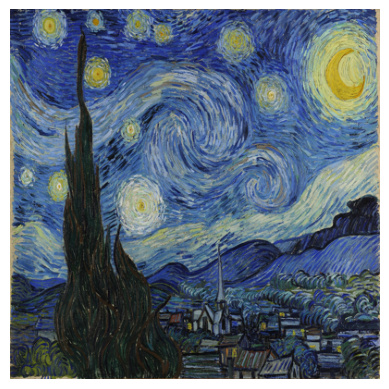

In [ ]:
style_image = load_img("images/Starry Night.jpg", img_size)

plt.imshow(style_image[0].numpy().astype("uint8"))
plt.axis("off")
plt.show()

### 4.3 Inicialización de la imagen a generar
La imagen generada $G$ se inicializa sumando a la imagen de contenido una cantidad de ruido.

Esta estrategia hace que los valores iniciales de la imagen generada estén correlacionados con el contenido original, lo cual ayuda a que el modelo capture más rápidamente el contenido durante la optimización.


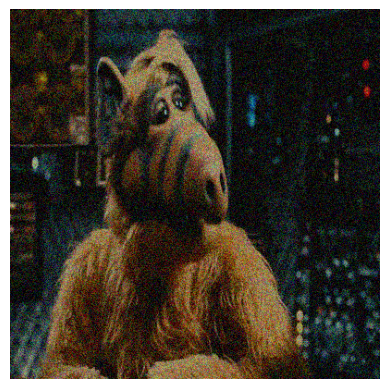

In [ ]:
# Initialize generated_image in RGB 0..255 with noise
noise = tf.random.uniform(tf.shape(content_image), minval=-127, maxval=127)
init = tf.clip_by_value(0.6 * content_image + 0.4 * noise, 0.0, 255.0)

generated_image = tf.Variable(init)  # dtype float32, range 0..255

plt.imshow(generated_image.numpy()[0].astype("uint8"))
plt.axis("off")
plt.show()

### 4.4 Definir las capas de estilo y la de contenido

¿Cómo elegir los pesos para cada capa de estilo?

- Las **capas más superficiales** capturan características **locales**, como texturas y patrones finos.  
  → Asignar pesos más altos a estas capas produce una transferencia de estilo más precisa y rica en detalles.

- Las **capas más profundas** capturan características de **alto nivel**, más globales y menos localizadas.  
  → Asignar pesos más altos a estas capas produce una transferencia de estilo más suave y menos detallada.

Los pesos deben cumplir que: $\sum_{l=1}^{L} \lambda^{[l]} = 1$

Puedes experimentar modificando las capas y sus pesos para observar cómo cambia la imagen generada.


In [ ]:
content_layer = [('block5_conv4', 1)]

#  list of style layer names and their coefficients
style_layers = [
    ('block1_conv1', 0.35),
    ('block2_conv1', 0.3),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.1),
    ('block5_conv1', 0.05)]

### 4.5 Extraer activaciones
Se construye un extractor de características y se pasan por él las imágenes de contenido y de estilo para obtener sus activaciones correspondientes: $a(C)$ y $a(S)$.

Es fundamental **preprocesar las imágenes antes de ingresarlas en la VGG-19**, aplicando la conversión de RGB a BGR y la substracción de la media por canal, tal como espera el modelo original. Esto garantiza que las activaciones obtenidas sean coherentes con los pesos con los que la red fue entrenada.

In [ ]:
layers = content_layer + style_layers

outputs = [vgg.get_layer(l[0]).output for l in layers]
extractor = tf.keras.Model([vgg.input], outputs)

a_C = extractor(preprocess_input(content_image))[0]   # content layer activation tensor
a_S = extractor(preprocess_input(style_image))[1:]    # list of style activation tensors

## 5 - Entrenamiento

### 5.1 - Paso de entrenamiento

* Utiliza el optimizador Adam para minimizar el coste total $J$.
* Emplea una tasa de **aprendizaje de 0.01**.
* La actualización de la imagen se realiza mediante **tf.GradientTape**, que calcula los gradientes del coste respecto a la imagen generada.
* Es importante destacar que, en este proceso, la optimización **ajusta los valores de los píxeles de la imagen generada**, no los parámetros de la red neuronal.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    """
    generated_image: tf.Variable dtype=float32 range 0..255 (shape (1,H,W,3))
    """
    with tf.GradientTape() as tape:
        # Compute a_G as for the current generated image
        a_G = extractor(preprocess_input(generated_image))

        J_style = compute_style_cost(a_S, a_G[1:], style_layers)    # Compute the style cost
        J_content = compute_content_cost(a_C, a_G[0])               # Compute the content cost
        J = total_cost(J_content, J_style, alpha = 10, beta = 100)  # Compute the total cost

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 255.0))

    return J

### 5.2 - Optimización
La siguiente celda ejecuta el proceso completo de optimización, mostrando la imagen generada cada cierto número de épocas.
Al finalizar, guarda la imagen resultante tras el estilo transferido.

Epoch 6000
Epoch 12000
Epoch 18000
Epoch 24000
Epoch 30000


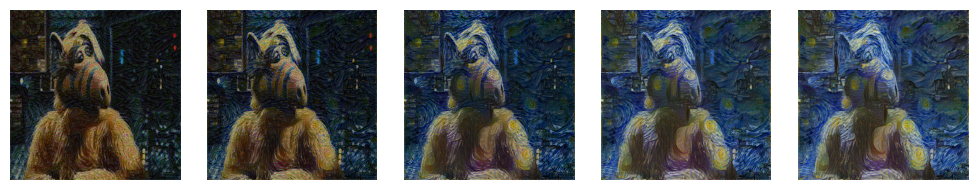

In [ ]:
epochs = 30000
saved_images = []

for i in range(epochs):
    train_step(generated_image)

    if (i+1) % 6000 == 0:
        print(f"Epoch {i+1}")
        img = generated_image.numpy()[0].clip(0, 255).astype("uint8")
        saved_images.append(img)

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for ax, img in zip(axes.flatten(), saved_images):
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Save the final generated image
plt.imsave("images/style_transferred.jpg", saved_images[-1])

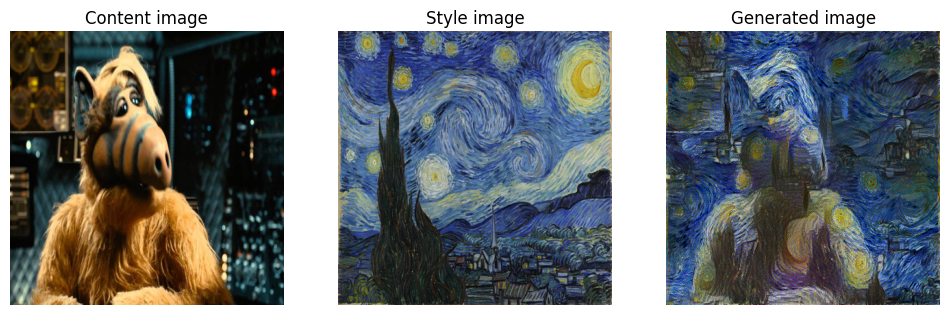

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(12, 4))

images = [
    (content_image.numpy()[0].astype("uint8"), "Content image"),
    (style_image.numpy()[0].astype("uint8"), "Style image"),
    (generated_image.numpy()[0].astype("uint8"), "Generated image"),
]

for i, (img, title) in enumerate(images, start=1):
    ax = fig.add_subplot(1, 3, i)
    ax.imshow(img)
    ax.title.set_text(title)
    ax.axis("off")

plt.show()

## 6 - Referencias

Este proyecto se inspira profundamente en el laboratorio final *Art Generation with Neural Style Transfer* del curso **Convolutional Neural Networks** de DeepLearning.AI.

El algoritmo de **Neural Style Transfer** fue introducido por *Gatys et al. (2015)*. Las explicaciones de *Harish Narayanan* y del usuario de GitHub **log0** también fueron de gran utilidad para orientar y complementar esta implementación. La red preentrenada utilizada es **VGG-19**, propuesta por *Simonyan y Zisserman (2015)*.

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge (2015). [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

- Harish Narayanan. [Convolutional Neural Networks for Artistic Style Transfer](https://harishnarayanan.org/writing/artistic-style-transfer/)

- log0. [TensorFlow Implementation of “A Neural Algorithm of Artistic Style”](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)

- Karen Simonyan, Andrew Zisserman (2015). [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf)